<a href="https://colab.research.google.com/github/AndreaCastiella/Sequences-Time-Series-and-Prediction/blob/main/S%2BP_Week_4_Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-05-07 08:40:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 172.217.214.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-05-07 08:40:01 (97.7 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



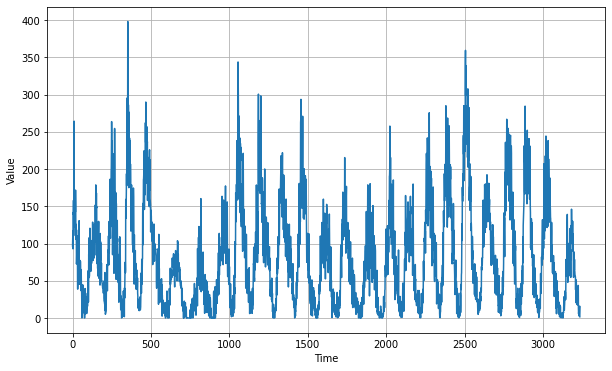

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

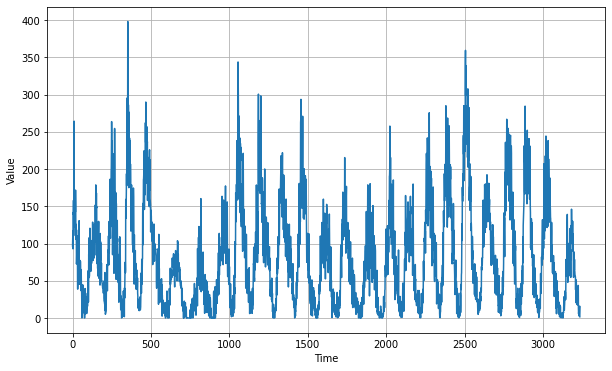

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 8s 323ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 4s 329ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 4s 325ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 4s 328ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 4s 327ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 4s 328ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 4s 329ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 4s 329ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 4s 330ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/

(1e-08, 0.0001, 0.0, 60.0)

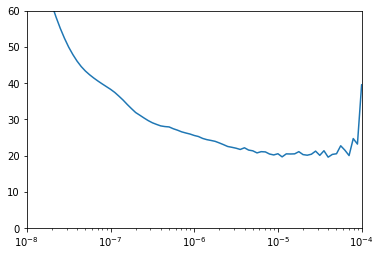

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 123ms/step - loss: 46.0843 - mae: 46.5810
Epoch 2/500
30/30 [==============================] - 4s 125ms/step - loss: 24.2473 - mae: 24.7416
Epoch 3/500
30/30 [==============================] - 4s 127ms/step - loss: 20.5502 - mae: 21.0429
Epoch 4/500
30/30 [==============================] - 4s 125ms/step - loss: 20.6815 - mae: 21.1749
Epoch 5/500
30/30 [==============================] - 4s 125ms/step - loss: 18.5776 - mae: 19.0697
Epoch 6/500
30/30 [==============================] - 4s 125ms/step - loss: 19.1964 - mae: 19.6886
Epoch 7/500
30/30 [==============================] - 4s 128ms/step - loss: 19.6478 - mae: 20.1394
Epoch 8/500
30/30 [==============================] - 4s 126ms/step - loss: 18.3113 - mae: 18.8028
Epoch 9/500
30/30 [==============================] - 4s 126ms/step - loss: 18.0987 - mae: 18.5897
Epoch 10/500
30/30 [==============================] - 4s 127ms/step - loss: 18.0157 - mae: 18.5057
Epoch 11/500
30/30 

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

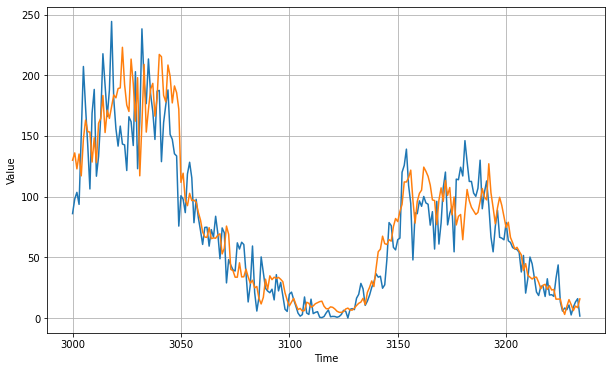

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

18.597055

<Figure size 432x288 with 0 Axes>

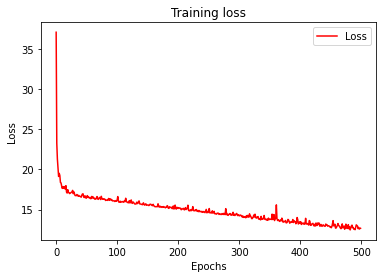

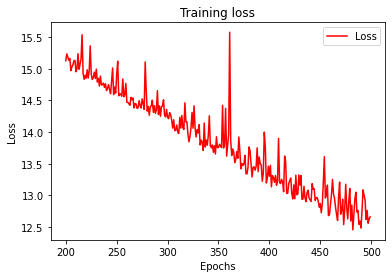

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[129.97011   136.00204   122.85179   135.07614   117.091705  147.54176
 163.0347    153.48497   153.16194   128.4716    148.45369   128.04372
 160.43205   164.48273   183.32065   152.77457   171.17647   164.42868
 173.97818   183.75473   181.3867    189.04709   189.56433   223.00847
 192.25648   175.44098   170.15477   213.30559   193.08322   162.19945
 197.9734    117.12852   160.27892   208.90076   153.14806   171.69081
 188.37238   193.29735   166.27257   181.40906   217.12553   215.26704
 183.39413   178.08116   208.41837   199.27568   177.19196   191.17264
 185.63992   172.07913   111.70945   119.28775    97.20224    92.52392
 102.697845   96.68967    97.14924    95.44263    87.10489    80.79253
  70.90856    66.66362    66.389336   74.40083    65.3535     65.99605
  65.67673    68.2296     69.37164    52.79219    57.409275   75.718575
  68.97775    39.99691    38.979717   33.590813   33.590813   45.462288
  33.83563    33.941505   40.170795   33.827366   28.609896   31.08371
  24